In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=os.path.join('.', 'data'), train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root=os.path.join('.', 'data'), train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


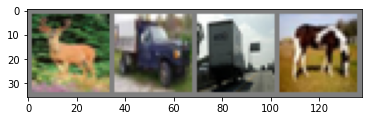

 deer truck truck horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flatten_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flatten_features(self, x):
        xsize = x.size()[1:]
        num_features = 1
        for num in xsize:
            num_features *= num
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        net.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0
            
print('Finished Training')

[1,  2000] loss : 2.210
[1,  4000] loss : 1.834
[1,  6000] loss : 1.691
[1,  8000] loss : 1.628
[1, 10000] loss : 1.535
[1, 12000] loss : 1.480
[2,  2000] loss : 1.385
[2,  4000] loss : 1.373
[2,  6000] loss : 1.360
[2,  8000] loss : 1.329
[2, 10000] loss : 1.289
[2, 12000] loss : 1.297
Finished Training


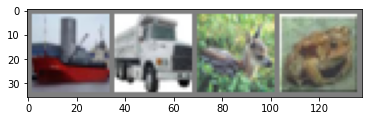

Ground_Truth:   ship truck  deer  frog


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground_Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Predicted:   ship truck  deer  frog


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(labels.size())
print(labels.size(0))
sqztest = (labels == labels)
print(sqztest)
print(sqztest.squeeze())
with torch.no_grad():
    images, labels = dataiter.next()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c1 = (predicted == labels)
    c = (predicted == labels).squeeze()  # 压缩掉所有值为1的维度，如果给定参数，则直对给定维度进行压缩
    print(c1)
    print(c1.size())
    print(c)
    print(c.size())

torch.Size([4])
4
tensor([True, True, True, True])
tensor([True, True, True, True])
tensor([False, False,  True, False])
torch.Size([4])
tensor([False, False,  True, False])
torch.Size([4])


In [16]:
class_total = list(0.0 for i in range(10))
class_correct = list(0.0 for i in range(10))

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (labels == predicted).squeeze()
        for i in range(4):
            label = labels[i]
            class_total[label] += 1
            class_correct[label] += c[i].item()
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], class_correct[i] / class_total[i] * 100))

Accuracy of plane : 58 %
Accuracy of   car : 76 %
Accuracy of  bird : 34 %
Accuracy of   cat : 38 %
Accuracy of  deer : 40 %
Accuracy of   dog : 49 %
Accuracy of  frog : 69 %
Accuracy of horse : 65 %
Accuracy of  ship : 58 %
Accuracy of truck : 57 %


In [17]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
def train_epochs(epochs):
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            net.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0

    print('Finished Training')

In [22]:
def test_correct():
    correct = 0
    total = 0
    class_total = list(0.0 for i in range(10))
    class_correct = list(0.0 for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (labels == predicted).squeeze()
            for i in range(4):
                label = labels[i]
                class_total[label] += 1
                class_correct[label] += c[i].item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], class_correct[i] / class_total[i] * 100))

In [23]:
test_correct()

Accuracy of the network on the 10000 test images: 59 %
Accuracy of plane : 75 %
Accuracy of   car : 85 %
Accuracy of  bird : 47 %
Accuracy of   cat : 44 %
Accuracy of  deer : 43 %
Accuracy of   dog : 43 %
Accuracy of  frog : 69 %
Accuracy of horse : 65 %
Accuracy of  ship : 69 %
Accuracy of truck : 52 %


In [26]:
train_epochs(2)

[1,  2000] loss : 1.023
[1,  4000] loss : 1.062
[1,  6000] loss : 1.033
[1,  8000] loss : 1.057
[1, 10000] loss : 1.047
[1, 12000] loss : 1.029
[2,  2000] loss : 0.965
[2,  4000] loss : 0.959
[2,  6000] loss : 0.987
[2,  8000] loss : 1.000
[2, 10000] loss : 0.983
[2, 12000] loss : 1.021
Finished Training


In [27]:
test_correct()

Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 66 %
Accuracy of   car : 80 %
Accuracy of  bird : 57 %
Accuracy of   cat : 37 %
Accuracy of  deer : 51 %
Accuracy of   dog : 41 %
Accuracy of  frog : 74 %
Accuracy of horse : 58 %
Accuracy of  ship : 83 %
Accuracy of truck : 58 %


In [28]:
train_epochs(2)

[1,  2000] loss : 0.906
[1,  4000] loss : 0.954
[1,  6000] loss : 0.928
[1,  8000] loss : 0.951
[1, 10000] loss : 0.955
[1, 12000] loss : 0.945
[2,  2000] loss : 0.858
[2,  4000] loss : 0.896
[2,  6000] loss : 0.890
[2,  8000] loss : 0.913
[2, 10000] loss : 0.910
[2, 12000] loss : 0.948
Finished Training


In [29]:
test_correct()

Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 74 %
Accuracy of   car : 67 %
Accuracy of  bird : 37 %
Accuracy of   cat : 54 %
Accuracy of  deer : 55 %
Accuracy of   dog : 39 %
Accuracy of  frog : 63 %
Accuracy of horse : 74 %
Accuracy of  ship : 74 %
Accuracy of truck : 80 %


In [30]:
train_epochs(10)

[1,  2000] loss : 0.840
[1,  4000] loss : 0.844
[1,  6000] loss : 0.861
[1,  8000] loss : 0.878
[1, 10000] loss : 0.880
[1, 12000] loss : 0.903
[2,  2000] loss : 0.767
[2,  4000] loss : 0.829
[2,  6000] loss : 0.833
[2,  8000] loss : 0.827
[2, 10000] loss : 0.881
[2, 12000] loss : 0.885
[3,  2000] loss : 0.754
[3,  4000] loss : 0.800
[3,  6000] loss : 0.807
[3,  8000] loss : 0.805
[3, 10000] loss : 0.845
[3, 12000] loss : 0.840
[4,  2000] loss : 0.755
[4,  4000] loss : 0.780
[4,  6000] loss : 0.792
[4,  8000] loss : 0.807
[4, 10000] loss : 0.805
[4, 12000] loss : 0.812
[5,  2000] loss : 0.716
[5,  4000] loss : 0.744
[5,  6000] loss : 0.767
[5,  8000] loss : 0.789
[5, 10000] loss : 0.808
[5, 12000] loss : 0.800
[6,  2000] loss : 0.694
[6,  4000] loss : 0.701
[6,  6000] loss : 0.752
[6,  8000] loss : 0.756
[6, 10000] loss : 0.804
[6, 12000] loss : 0.769
[7,  2000] loss : 0.665
[7,  4000] loss : 0.691
[7,  6000] loss : 0.749
[7,  8000] loss : 0.742
[7, 10000] loss : 0.782
[7, 12000] loss 

In [31]:
test_correct()

Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 57 %
Accuracy of   car : 73 %
Accuracy of  bird : 44 %
Accuracy of   cat : 55 %
Accuracy of  deer : 55 %
Accuracy of   dog : 40 %
Accuracy of  frog : 72 %
Accuracy of horse : 55 %
Accuracy of  ship : 78 %
Accuracy of truck : 68 %


In [32]:
train_epochs(10)

[1,  2000] loss : 0.623
[1,  4000] loss : 0.624
[1,  6000] loss : 0.711
[1,  8000] loss : 0.708
[1, 10000] loss : 0.705
[1, 12000] loss : 0.742
[2,  2000] loss : 0.615
[2,  4000] loss : 0.652
[2,  6000] loss : 0.673
[2,  8000] loss : 0.704
[2, 10000] loss : 0.694
[2, 12000] loss : 0.735
[3,  2000] loss : 0.593
[3,  4000] loss : 0.649
[3,  6000] loss : 0.663
[3,  8000] loss : 0.669
[3, 10000] loss : 0.705
[3, 12000] loss : 0.694
[4,  2000] loss : 0.568
[4,  4000] loss : 0.650
[4,  6000] loss : 0.654
[4,  8000] loss : 0.675
[4, 10000] loss : 0.666
[4, 12000] loss : 0.730
[5,  2000] loss : 0.575
[5,  4000] loss : 0.606
[5,  6000] loss : 0.651
[5,  8000] loss : 0.685
[5, 10000] loss : 0.696
[5, 12000] loss : 0.699
[6,  2000] loss : 0.582
[6,  4000] loss : 0.607
[6,  6000] loss : 0.626
[6,  8000] loss : 0.662
[6, 10000] loss : 0.669
[6, 12000] loss : 0.730
[7,  2000] loss : 0.600
[7,  4000] loss : 0.610
[7,  6000] loss : 0.642
[7,  8000] loss : 0.671
[7, 10000] loss : 0.672
[7, 12000] loss 

In [33]:
test_correct()

Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 64 %
Accuracy of   car : 83 %
Accuracy of  bird : 43 %
Accuracy of   cat : 44 %
Accuracy of  deer : 48 %
Accuracy of   dog : 52 %
Accuracy of  frog : 70 %
Accuracy of horse : 70 %
Accuracy of  ship : 64 %
Accuracy of truck : 62 %


In [35]:
class Net_ex(nn.Module):
    def __init__(self):
        super(Net_ex, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flatten_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flatten_features(self, x):
        xsize = x.size()[1:]
        num_features = 1
        for num in xsize:
            num_features *= num
        return num_features
    
net_ex = Net_ex()
print(net_ex)

Net_ex(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [36]:
def train_epochs(net, device, epochs):
    
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            net.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0

    print('Finished Training')

In [37]:
def test_correct(net, device):
    net.to(device)
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
    correct = 0
    total = 0
    class_total = list(0.0 for i in range(10))
    class_correct = list(0.0 for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (labels == predicted).squeeze()
            for i in range(4):
                label = labels[i]
                class_total[label] += 1
                class_correct[label] += c[i].item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], class_correct[i] / class_total[i] * 100))

In [39]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

test_correct(net_ex, device)
train_epochs(net_ex, device, 10)
test_correct(net_ex, device)
train_epochs(net_ex, device, 10)
test_correct(net_ex, device)
train_epochs(net_ex, device, 10)
test_correct(net_ex, device)
train_epochs(net_ex, device, 10)
test_correct(net_ex, device)
train_epochs(net_ex, device, 10)
test_correct(net_ex, device)

Accuracy of the network on the 10000 test images: 10 %
Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer :  0 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck : 100 %
[1,  2000] loss : 2.170
[1,  4000] loss : 1.810
[1,  6000] loss : 1.639
[1,  8000] loss : 1.530
[1, 10000] loss : 1.489
[1, 12000] loss : 1.411
[2,  2000] loss : 1.374
[2,  4000] loss : 1.359
[2,  6000] loss : 1.311
[2,  8000] loss : 1.297
[2, 10000] loss : 1.264
[2, 12000] loss : 1.223
[3,  2000] loss : 1.177
[3,  4000] loss : 1.163
[3,  6000] loss : 1.147
[3,  8000] loss : 1.147
[3, 10000] loss : 1.128
[3, 12000] loss : 1.146
[4,  2000] loss : 1.053
[4,  4000] loss : 1.058
[4,  6000] loss : 1.054
[4,  8000] loss : 1.065
[4, 10000] loss : 1.057
[4, 12000] loss : 1.034
[5,  2000] loss : 0.963
[5,  4000] loss : 0.945
[5,  6000] loss : 0.966
[5,  8000] loss : 0.956
[5, 10000] loss : 0.98

[6, 10000] loss : 0.553
[6, 12000] loss : 0.581
[7,  2000] loss : 0.491
[7,  4000] loss : 0.495
[7,  6000] loss : 0.542
[7,  8000] loss : 0.569
[7, 10000] loss : 0.542
[7, 12000] loss : 0.576
[8,  2000] loss : 0.458
[8,  4000] loss : 0.517
[8,  6000] loss : 0.552
[8,  8000] loss : 0.568
[8, 10000] loss : 0.588
[8, 12000] loss : 0.558
[9,  2000] loss : 0.453
[9,  4000] loss : 0.526
[9,  6000] loss : 0.510
[9,  8000] loss : 0.571
[9, 10000] loss : 0.567
[9, 12000] loss : 0.599
[10,  2000] loss : 0.464
[10,  4000] loss : 0.496
[10,  6000] loss : 0.571
[10,  8000] loss : 0.564
[10, 10000] loss : 0.582
[10, 12000] loss : 0.575
Finished Training
Accuracy of the network on the 10000 test images: 61 %
Accuracy of plane : 66 %
Accuracy of   car : 65 %
Accuracy of  bird : 50 %
Accuracy of   cat : 37 %
Accuracy of  deer : 60 %
Accuracy of   dog : 59 %
Accuracy of  frog : 77 %
Accuracy of horse : 56 %
Accuracy of  ship : 74 %
Accuracy of truck : 71 %
